In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Piecewise Linear Interoplation (Interpolation Code 0)



## The Single Bin Case

In [106]:
def interpolate(down,nom,up,alpha):
    delta_up = up - nom
    delta_down = nom - down
    if alpha > 0:
        return delta_up*alpha
    else:
        return delta_down*alpha

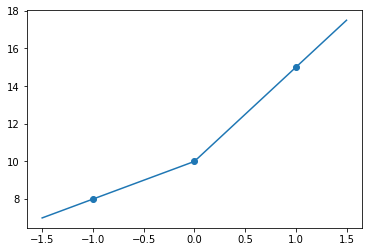

In [122]:
down_1,nom_1,up_1 = 8,10,15

alphas = np.linspace(-1.5,1.5)
interpolated_deltas = [interpolate(down_1,nom_1,up_1,alpha) for alpha in alphas]


plt.plot(alphas,[nom_1+delta for delta in interpolated_deltas])
plt.scatter((-1,0,1),(down_1,nom_1,up_1))

## Multi-bin Case (interpolating a logical Histogram from three Measurements)

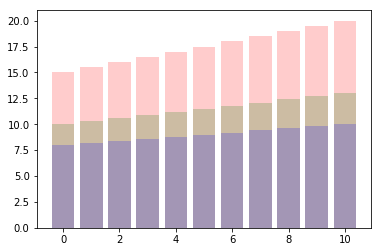

In [123]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)

bincenters = np.arange(len(h))
for c,h in zip(['r','g','b'],[histogram_up,histogram_nom,histogram_down]):
    plt.bar(bincenters,h, alpha = 0.2, facecolor = c)

In [124]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### At a single alpha value alpha = 0.5

<BarContainer object of 11 artists>

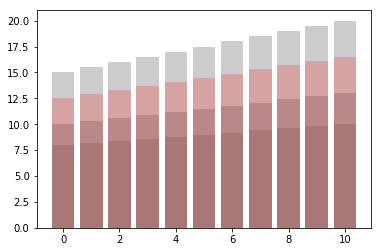

In [140]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)

at_p05 = [nom + interpolate(dn,nom,up,0.5) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]

bincenters = np.arange(len(h))
for c,h in zip(['k','#222222','#444444'],[histogram_up,histogram_nom,histogram_down]):
    plt.bar(bincenters,h, alpha = 0.2, facecolor = c)
    
plt.bar(bincenters,at_p05, facecolor = 'r', alpha = 0.2)

### At a single alpha value alpha = 0.5

In [143]:
alphas = np.linspace(-1,1,11)

at_alphas = []

for alpha in alphas:
    inerpolated_hist = [nom + interpolate(dn,nom,up,alpha) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]
    at_alphas.append(inerpolated_hist)

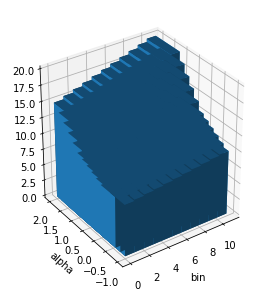

In [144]:
# setup the figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')

# fake data
x,y = np.meshgrid(bincenters,alphas)

top = np.asarray(at_alphas).ravel()
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x.ravel(), y.ravel(), bottom, width, depth, top, shade=True)
ax1.set_xlabel('bin')
ax1.set_ylabel('alpha')

ax1.view_init(azim=-125)
plt.show()

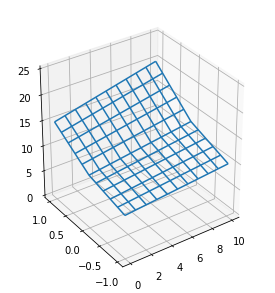

In [145]:
# setup the figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')

# fake data
x,y = np.meshgrid(bincenters,alphas)

top = np.asarray(at_alphas).ravel()
bottom = np.zeros_like(top)
width = depth = 1

ax1.plot_wireframe(x, y,top.reshape(len(bincenters),len(alphas)))
ax1.set_zlim(0,25)
ax1.view_init(azim=-125)
plt.show()